## Part 02

## Dataset Overview

In [12]:
dataset_path = './realwaste/realwaste-main/RealWaste'

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [14]:
num_classes = 9
batch_size = 32
learning_rate = 0.001
num_epochs = 20

In [15]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataset_size = len(dataset)
indices = torch.randperm(dataset_size).tolist()

train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)


# Print dataset information
print("Classes:", dataset.classes)
print(f"Total images: {len(dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Total images: 4752
Training set size: 2851
Validation set size: 950
Test set size: 951


## ResNet

### Loading the pretrained model

In [16]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)

nn.init.xavier_uniform_(model.fc.weight)
nn.init.zeros_(model.fc.bias)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

print(f"Model is running on {device}")

Model is running on cuda


### Fine tunning the model

In [17]:
# Training and Validation 
num_epochs = 20  
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training 
    model.train()  
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  
        outputs = model(inputs)  
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer.step()  

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_loss /= total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # Validation 
    model.eval()  
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
        f"Train Loss: {train_loss:.4f}, "
        f"Train Accuracy: {train_accuracy:.2f}%",
        f"Validation Loss: {val_loss:.4f}, "
        f"Validation Accuracy: {val_accuracy:.2f}%")



Epoch 1/20, Train Loss: 1.4362, Train Accuracy: 0.49% Validation Loss: 1.0811, Validation Accuracy: 0.61%
Epoch 2/20, Train Loss: 0.9367, Train Accuracy: 0.68% Validation Loss: 1.0090, Validation Accuracy: 0.64%
Epoch 3/20, Train Loss: 0.8264, Train Accuracy: 0.71% Validation Loss: 0.8685, Validation Accuracy: 0.70%
Epoch 4/20, Train Loss: 0.7337, Train Accuracy: 0.75% Validation Loss: 0.8363, Validation Accuracy: 0.71%
Epoch 5/20, Train Loss: 0.6686, Train Accuracy: 0.76% Validation Loss: 0.7935, Validation Accuracy: 0.73%
Epoch 6/20, Train Loss: 0.6560, Train Accuracy: 0.77% Validation Loss: 0.7883, Validation Accuracy: 0.73%
Epoch 7/20, Train Loss: 0.6099, Train Accuracy: 0.79% Validation Loss: 0.7984, Validation Accuracy: 0.73%
Epoch 8/20, Train Loss: 0.5968, Train Accuracy: 0.79% Validation Loss: 0.8045, Validation Accuracy: 0.73%
Epoch 9/20, Train Loss: 0.5437, Train Accuracy: 0.82% Validation Loss: 0.8088, Validation Accuracy: 0.73%
Epoch 10/20, Train Loss: 0.5159, Train Accurac

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_labels = []
all_predictions = []

### Evaluating the model

In [21]:
# Testing
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0


model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
test_accuracy = correct_test / total_test
test_loss /= total_test
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.8071, Test Accuracy: 0.7274


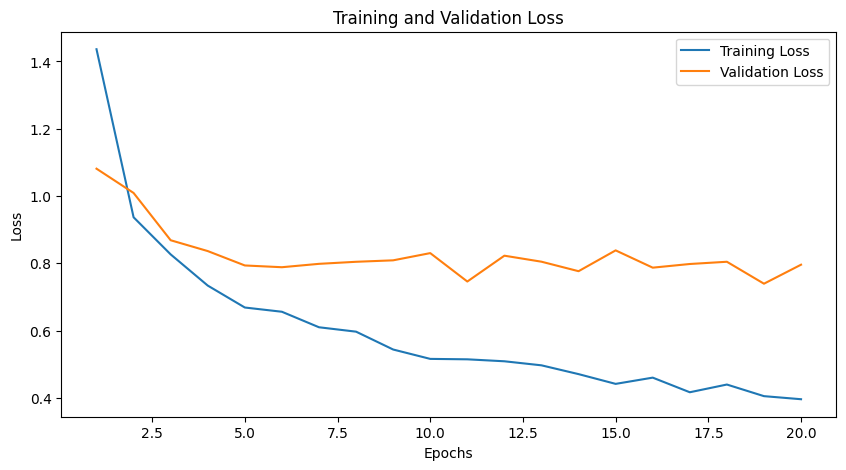

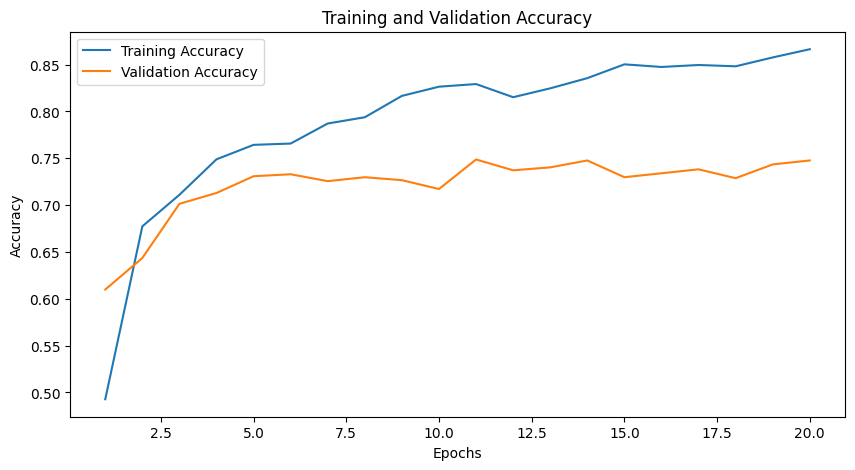

In [22]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

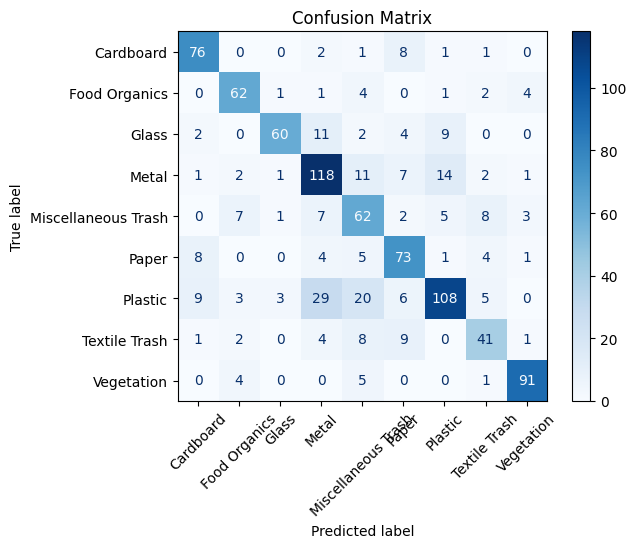

In [23]:
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

## DenseNet

### Loading the pretrained model

In [24]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, num_classes)

nn.init.xavier_uniform_(model.classifier.weight)
nn.init.zeros_(model.classifier.bias)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

print(f"Model is running on {device}")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/pasindupnk/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:03<00:00, 9.23MB/s]


Model is running on cuda


### Fine tunning the model

In [25]:
# Training and Validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_loss /= total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}")

Epoch 1/20, Train Loss: 1.9297, Train Accuracy: 0.34, Validation Loss: 1.4091, Validation Accuracy: 0.49
Epoch 2/20, Train Loss: 1.1414, Train Accuracy: 0.59, Validation Loss: 1.0602, Validation Accuracy: 0.62
Epoch 3/20, Train Loss: 0.9154, Train Accuracy: 0.68, Validation Loss: 0.9550, Validation Accuracy: 0.67
Epoch 4/20, Train Loss: 0.7823, Train Accuracy: 0.73, Validation Loss: 0.8637, Validation Accuracy: 0.69
Epoch 5/20, Train Loss: 0.7062, Train Accuracy: 0.75, Validation Loss: 0.8227, Validation Accuracy: 0.71
Epoch 6/20, Train Loss: 0.6511, Train Accuracy: 0.77, Validation Loss: 0.8039, Validation Accuracy: 0.71
Epoch 7/20, Train Loss: 0.6012, Train Accuracy: 0.80, Validation Loss: 0.7795, Validation Accuracy: 0.72
Epoch 8/20, Train Loss: 0.5862, Train Accuracy: 0.80, Validation Loss: 0.8148, Validation Accuracy: 0.72
Epoch 9/20, Train Loss: 0.5587, Train Accuracy: 0.81, Validation Loss: 0.7501, Validation Accuracy: 0.75
Epoch 10/20, Train Loss: 0.5173, Train Accuracy: 0.82, 

### Evaluating the model

In [26]:
# Testing
all_labels, all_predictions = [], []
model.eval()
test_loss, correct_test, total_test = 0.0, 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = correct_test / total_test
test_loss /= total_test
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.7478, Test Accuracy: 0.7442


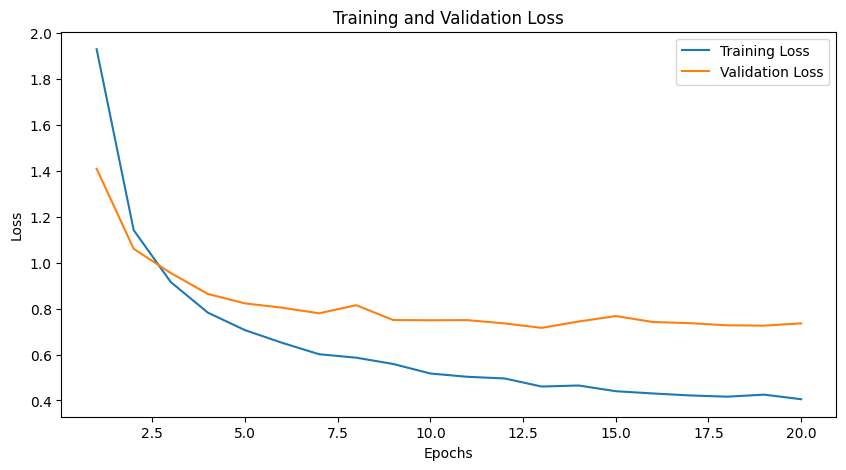

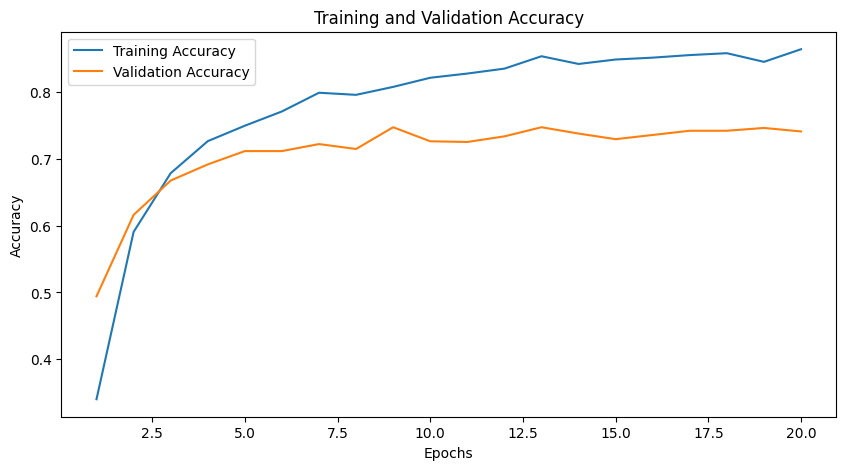

In [27]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

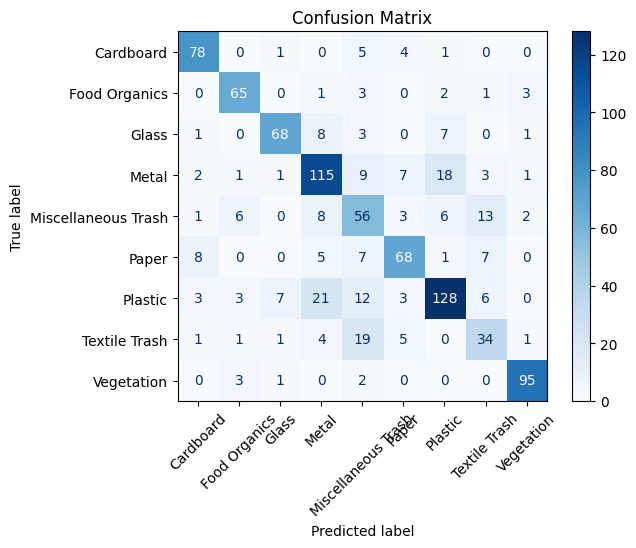

In [28]:
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()